In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Going from slow waves to a wake region

In [5]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [6]:
HET_REGION = 0

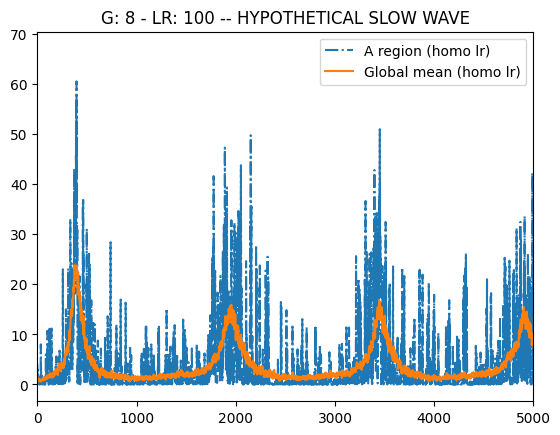

In [20]:

plt.plot(rates_dyn[HET_REGION,:], label="A region (homo lr)", linestyle="-.")
plt.plot(np.mean(rates_dyn,axis=0), label="Global mean (homo lr)", linestyle="-")
plt.xlim([0,5000])
plt.title(f"G: {params['G']} - LR: {LR} -- HYPOTHETICAL SLOW WAVE")
plt.legend()
plt.show()

In [15]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 10000
params_heter['lr_vector'][HET_REGION] = HET_LR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


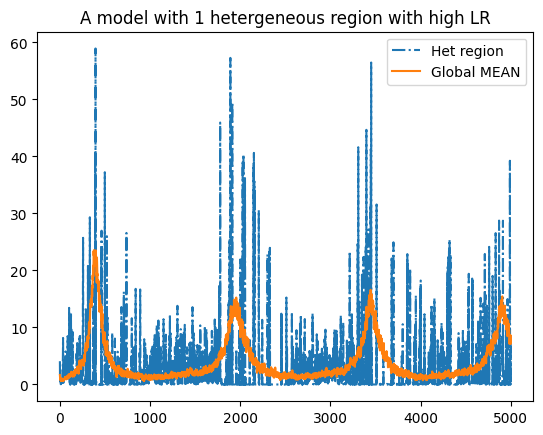

In [16]:
plt.plot(rates_heter[HET_REGION,:5000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")
plt.title("A model with 1 hetergeneous region with high LR")
plt.legend()
plt.show()

In [17]:
def get_autcorr(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = rates - np.mean(rates)    
    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    return autocorr



In [18]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_hete_restreg = get_autcorr(np.mean(rates_heter[1:],axis=0))


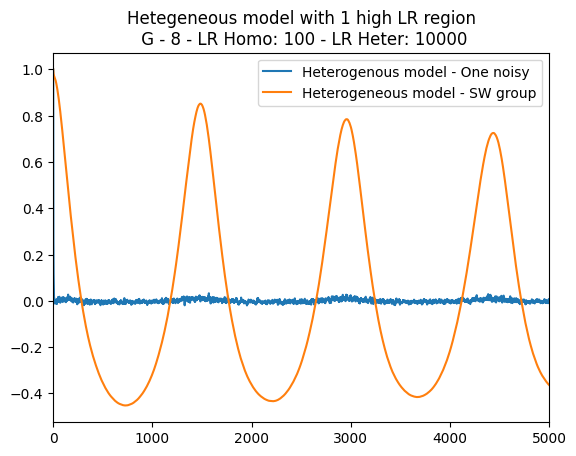

In [19]:
lags = np.arange(0,len(autocorr_hete_restreg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - One noisy')
plt.plot(lags,autocorr_hete_restreg,label='Heterogeneous model - SW group')

plt.xlim([0,5000])
plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Comparing a region in two different models with global SW

In [22]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [23]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 10000
params_heter['lr_vector'][HET_REGION] = HET_LR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


In [24]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_onereg = get_autcorr(rates_dyn[HET_REGION,:])


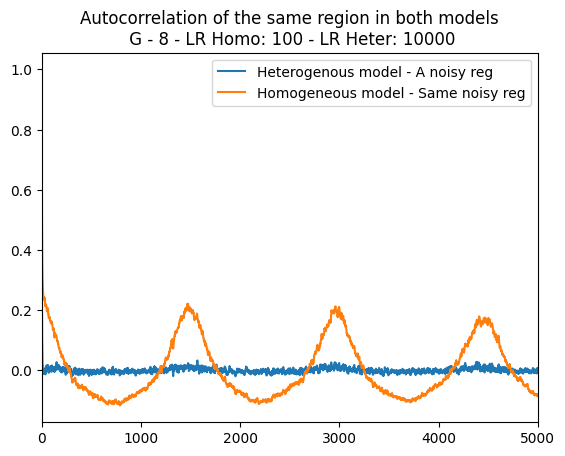

In [25]:
lags = np.arange(0,len(autocorr_homo_onereg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - A noisy reg')
plt.plot(lags,autocorr_homo_onereg,label='Homogeneous model - Same noisy reg')

plt.xlim([0,5000])
plt.title(f"Autocorrelation of the same region in both models\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Going from Awake regime to SW region

In [26]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [27]:
HET_REGION = 0

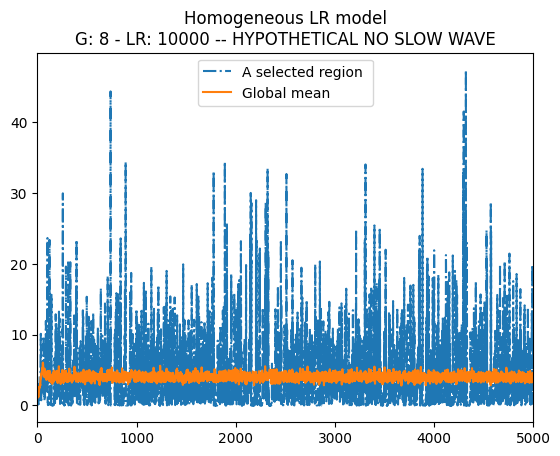

In [28]:

plt.plot(rates_dyn[HET_REGION,:], label="A selected region ", linestyle="-.")
plt.plot(np.mean(rates_dyn,axis=0), label="Global mean ", linestyle="-")
plt.xlim([0,5000])
plt.title(f"Homogeneous LR model\nG: {params['G']} - LR: {LR} -- HYPOTHETICAL NO SLOW WAVE")
plt.legend()
plt.show()

In [29]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 100
params_heter['lr_vector'][HET_REGION] = HET_LR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


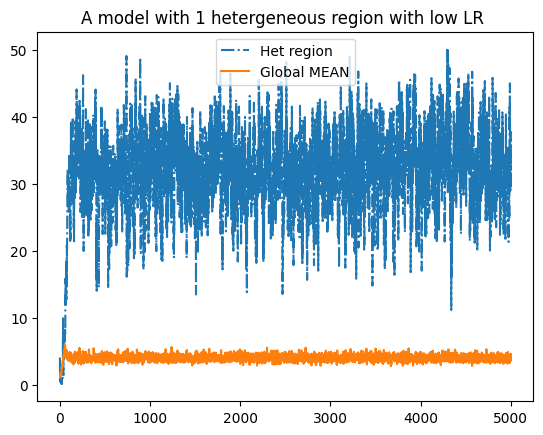

In [31]:
plt.plot(rates_heter[HET_REGION,:5000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")
#plt.ylim([0,12])
plt.title("A model with 1 hetergeneous region with low LR ")
plt.legend()
plt.show()

In [32]:
def get_autcorr(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = rates - np.mean(rates)    
    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    return autocorr



In [33]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_hete_restreg = get_autcorr(np.mean(rates_heter[1:],axis=0))


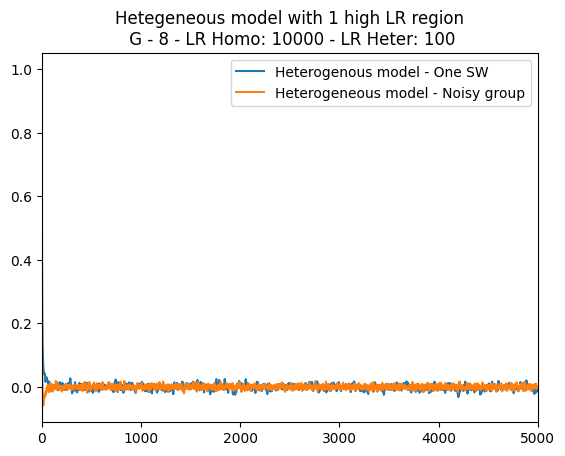

In [34]:
lags = np.arange(0,len(autocorr_hete_restreg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - One SW')
plt.plot(lags,autocorr_hete_restreg,label='Heterogeneous model - Noisy group')

plt.xlim([0,5000])
plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Comparing a region in two different models

In [35]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [36]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 100
params_heter['lr_vector'][HET_REGION] = HET_LR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


In [37]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_onereg = get_autcorr(rates_dyn[HET_REGION,:])


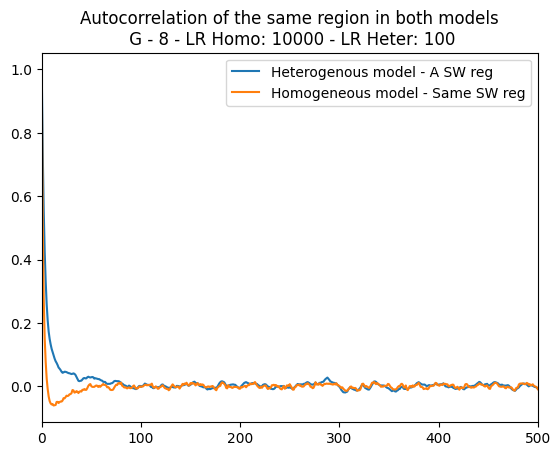

In [40]:
lags = np.arange(0,len(autocorr_homo_onereg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - A SW reg')
plt.plot(lags,autocorr_homo_onereg,label='Homogeneous model - Same SW reg')

plt.xlim([0,500])
plt.title(f"Autocorrelation of the same region in both models\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Groups of heterogeneous region in a Noisy context

In [41]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [42]:
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
less_connected = np.argsort(node_strength)[:10]


In [43]:

params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[less_connected] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


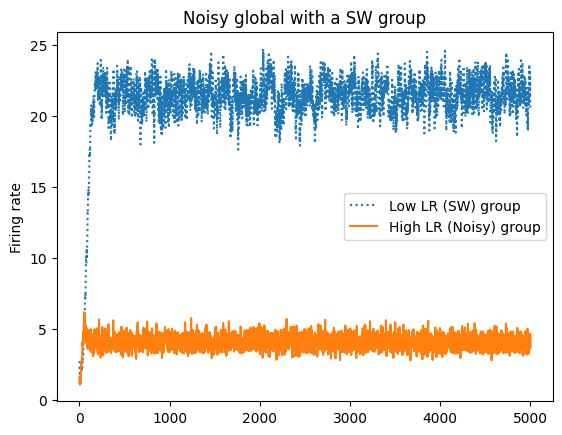

In [44]:
not_less_connected = np.setdiff1d(np.arange(N),less_connected)
plt.plot(np.mean(rates_heter[less_connected,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_less_connected,:5000],axis=0), label="High LR (Noisy) group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a SW group")
plt.legend()
plt.show()

In [45]:

autocorr_less_connected = get_autcorr(np.mean(rates_heter[less_connected,5000:],axis=0))
autocorr_not_less_connected = get_autcorr(np.mean(rates_heter[not_less_connected,5000:],axis=0))


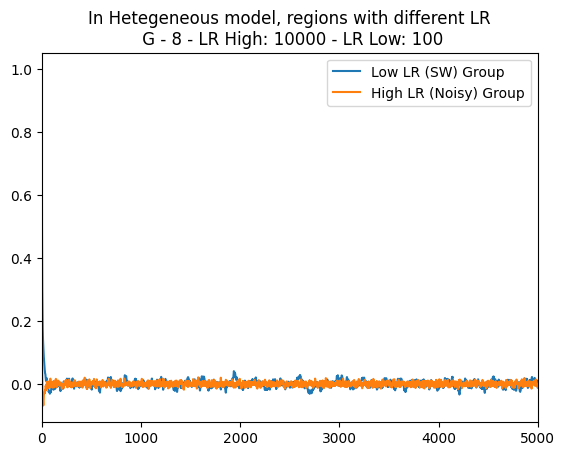

In [47]:
lags = np.arange(0,len(autocorr_less_connected))
plt.plot(lags, autocorr_less_connected,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_less_connected,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()

## Making a smart selection of Low LR group

In [48]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj'] =  DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [49]:
from bct import score_wu, rich_club_wu

In [50]:
node_strength = np.sum(C,axis=0)

In [51]:
score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 

In [52]:
highest_score = score_idxs[-1]
params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[highest_score] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


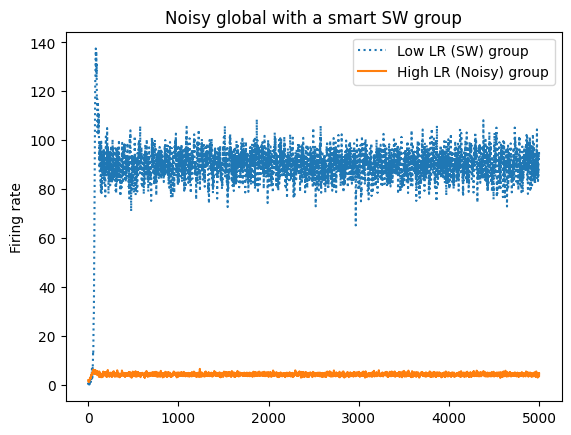

In [53]:
not_highest_score = np.setdiff1d(np.arange(N),highest_score)
plt.plot(np.mean(rates_heter[highest_score,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_highest_score,:5000],axis=0), label="High LR (Noisy) group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a smart SW group")
plt.legend()
plt.show()

In [54]:


autocorr_highest_score = get_autcorr(np.mean(rates_heter[highest_score,5000:],axis=0))
autocorr_not_highest_score = get_autcorr(np.mean(rates_heter[not_highest_score,5000:],axis=0))


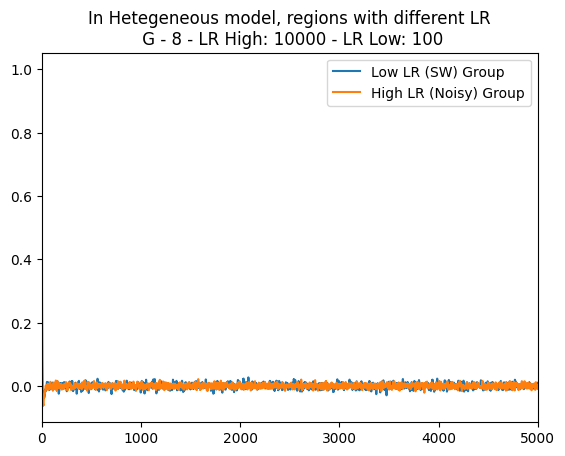

In [56]:
lags = np.arange(0,len(autocorr_highest_score))
plt.plot(lags, autocorr_highest_score,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_highest_score,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()